# TEAM NAME ETC

# Overview

Our task is to build an inferential linear regression model. Our model will help sellers understand their home valuations better. We will follow the assumptions of linear regression which are linearity, independence, normality, and homoscedasticity. We will also strive to have a high R^2 value, signaling that our parameters are explaining much of the total variance in house sales.

# Business Understanding

Our stakeholders are home sellers looking to get the best offer for their homes. Companies such as Opendoor, Zillow, make cash offers for homes and resell them. We want our stakeholders to be able to make an informed decision about their house's value. We will be focusing on the King County, Washington area. The county seat is Seattle.

The process generally includes evaluations of features, upgrades, amenities, and in-person inspections. They find comparable homes or 'comps' to provide a base range. Next, they make adjustments to the offer based on differences between comps. These differences can include features or neighborhood trends. Lastly, they make an offer and send someone to inspect the home.

Our job is to analyze the King County data set and provide solid valuation models. Different markets have slight differences, and we will report on the most important parameters when assessing home values in the King County area. Since they also do repairs, we will also look at factors that assess the condition and amount of repairs likely needed in the property. Sellers will be able to use our recommendations to evaluate offers in the King County area.

Our stakeholders are King County home sellers looking to get a fair offer for their homes. We want to provide them with the reasoning behind their home valuations. We will discuss the important features that affect a valuation based on analysis of previous home sales in the same area.

# Data Understanding

The data that we used is King County House Sales data from the King County assessor website. Our data set includes info about homes that sold between May 2nd, 2014 to May 24th, 2015. The target variable is price. We removed properties that were outside the realm of what our stakeholder purchases. This included homes with a price over $1,400,000, homes built before 1930, and homes with a lot size above 2 acres (87,120 square feet).

## *Loading our data*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower, TTestPower
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


In [2]:
df = pd.read_csv('data/kc_house_data.csv')

## Column formatting & Dealing with missing values

### *Renovated < 10 yrs*

In [3]:
df['yr_renovated'] = df['yr_renovated'].fillna(0.0)
df['renovated_less_10yrs'] = df['yr_renovated'] > 2010.0
df['renovated_less_10yrs'] = df['renovated_less_10yrs'].astype('int64')

### *Condition Column*

In [4]:
df['condition'].replace('Poor', '1', inplace=True)
df['condition'].replace('Fair', '2', inplace=True)
df['condition'].replace('Average', '3', inplace=True)
df['condition'].replace('Good', '4', inplace=True)
df['condition'].replace('Very Good', '5', inplace=True)
df['condition'] = df['condition'].astype(np.int64)

### *View Column*

In [5]:
df['view'].fillna('NONE', inplace=True)
df['view'].replace('NONE', '0', inplace=True)
df['view'].replace('FAIR', '1', inplace=True)
df['view'].replace('AVERAGE', '2', inplace=True)
df['view'].replace('GOOD', '3', inplace=True)
df['view'].replace('EXCELLENT', '4', inplace=True)
df['view'] = df['view'].astype(np.int64)

### *Sqft Basement Column*

In [6]:
df['sqft_basement'].replace(to_replace='?', value='0', inplace=True)
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'],errors='coerce')
df['has_basement'] = df['sqft_basement']
df.loc[df.has_basement > 0, 'has_basement'] = 1

### *Date Column*

In [7]:
# Converting to Datetime
df['date'] =  pd.to_datetime(df['date'], format='%m/%d/%Y')

### *Waterfront Column*

In [8]:
# Converting Waterfront to Binary
df['waterfront'] = df['waterfront'].fillna('0')
df['waterfront'].replace(to_replace='NO', value='0', inplace=True)
df['waterfront'].replace(to_replace='YES', value='1', inplace=True)
df['waterfront'] = pd.to_numeric(df['waterfront'],errors='coerce')

### *Grade Column*

In [9]:
# Converting Grade to Numeric
df['grade'] = df['grade'].str.slice(0,2).str.strip()
df['grade'] = df['grade'].astype(np.int64)

## *Dropping outliers*

In [10]:
#Dropping outliers
price_mean = np.mean(df['price'])
cut_off = np.std(df['price']) * 3
df.drop(df[df['price'] > price_mean + cut_off].index, inplace = True)
df.drop(df[df['price'] < price_mean - cut_off].index, inplace = True)
df.drop(df[df['bedrooms'] > 15].index, inplace=True)

In [11]:
df.shape

(21190, 23)

C:\Users\dougl\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

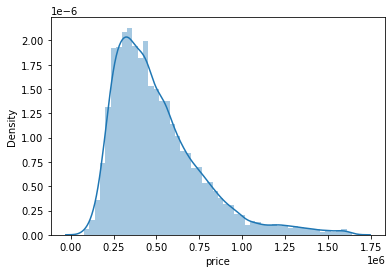

In [12]:
sns.distplot(df['price'])

# Modeling

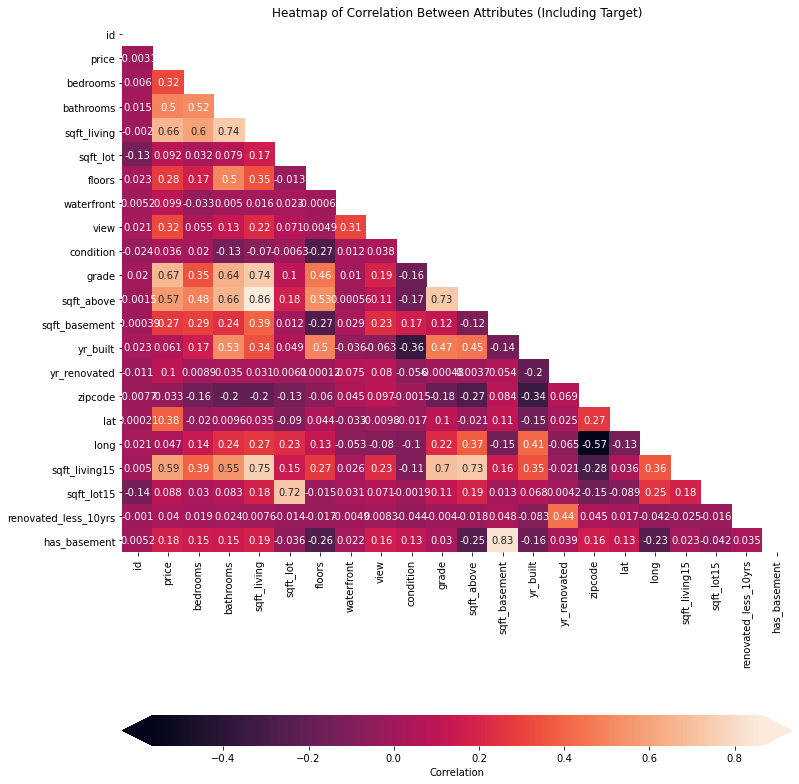

In [13]:
# heatmap_data = pd.concat([y_train, X_train], axis=1)
# corr = heatmap_data.corr()
corr = df.corr()
# Set up figure and axes
fig, ax = plt.subplots(figsize=(12, 15))
# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)
# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

# Baseline Model

In [14]:
baseline_y = df['price']
baseline_X = df.drop(['price', 'id', 'date'], axis=1)

In [15]:
baseline_X_train, baseline_X_test, baseline_y_train, baseline_y_test = train_test_split(baseline_X, baseline_y, random_state=42)

In [16]:
scaler = StandardScaler()
baseline_X_train_scaled = scaler.fit_transform(baseline_X_train)
baseline_X_test_scaled = scaler.fit_transform(baseline_X_test)
baseline_X_train_scaled = pd.DataFrame(baseline_X_train_scaled)
baseline_X_train_scaled.columns = baseline_X.columns

baseline_X_test_scaled = pd.DataFrame(baseline_X_test_scaled)
baseline_X_test_scaled.columns = baseline_X.columns

In [58]:
print(f'Train Mean: {baseline_y_train.mean()}, Test Mean: {baseline_y_test.mean()}')

Train Mean: 505325.3087087843, Test Mean: 512039.5039637599


In [23]:
baseline_model = LinearRegression()

# Fit the model on X_train_final and y_train
baseline_model.fit(baseline_X_train_scaled, baseline_y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
baseline_model.score(baseline_X_test_scaled, baseline_y_test)

0.7159096399795815

In [60]:
from sklearn.metrics import mean_squared_error

print(f'Train RMSE: {mean_squared_error(baseline_y_train, baseline_model.predict(baseline_X_train_scaled), squared=False)}')
print(f'Test RMSE: {mean_squared_error(baseline_y_test, baseline_model.predict(baseline_X_test_scaled), squared=False)}')

Train RMSE: 138826.54521251554
Test RMSE: 139522.47286647768


In [26]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(baseline_X_train_scaled, baseline_y_train)
dummy_regr.predict(baseline_X_train_scaled)
dummy_regr.score(baseline_X_test_scaled, baseline_y_test)

-0.0006578942651938036

## *Interpreting the baseline model*

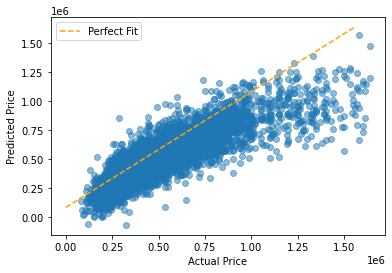

In [31]:
#LINEARITY
preds = baseline_model.predict(baseline_X_test_scaled)
fig, ax = plt.subplots()

perfect_line = np.arange(baseline_y_test.min(), baseline_y_test.max())
ax.plot(perfect_line, linestyle="--", color="orange", label="Perfect Fit")
ax.scatter(baseline_y_test, preds, alpha=0.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend();

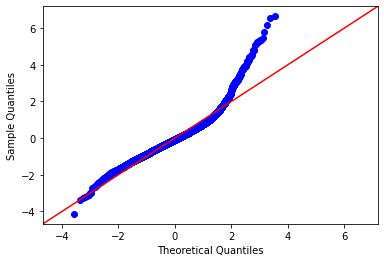

In [57]:
#NORMALITY
import scipy.stats as stats
preds = baseline_model.predict(baseline_X_test_scaled)
residuals = (baseline_y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

In [33]:
#MULTICOLLINEARITY (NEEDS TO BE <5 ALL CATEGORIES)
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(baseline_X_train_scaled.values, i) for i in range(baseline_X_train_scaled.shape[1])]
pd.Series(vif, index=baseline_X_train_scaled.columns, name="Variance Inflation Factor")

bedrooms                  1.725757
bathrooms                 3.241837
sqft_living             149.768399
sqft_lot                  1.983351
floors                    2.066365
waterfront                1.101259
view                      1.278353
condition                 1.238958
grade                     3.206788
sqft_above              126.135223
sqft_basement            40.923936
yr_built                  2.418925
yr_renovated              1.340859
zipcode                   1.674664
lat                       1.190267
long                      1.855483
sqft_living15             2.961611
sqft_lot15                2.017249
renovated_less_10yrs      1.230236
has_basement              3.692269
Name: Variance Inflation Factor, dtype: float64

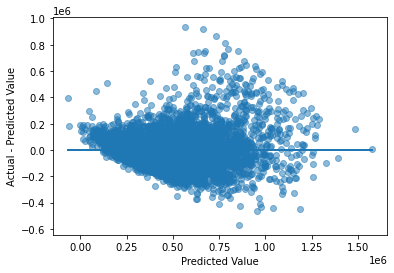

In [35]:
#HOMOSCEDASTICITY
fig, ax = plt.subplots()
ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(baseline_X_test_scaled))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

## First Model: Square Feet Living & Price

In [36]:
y = df["price"]
X = df.drop("price", axis=1)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

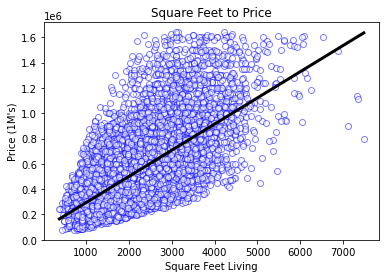

In [44]:
most_correlated_feature = X_train['sqft_living']
fig, ax = plt.subplots()
ax.scatter(most_correlated_feature, y_train, alpha=0.5, color ='white', edgecolor='blue')
ax.set_xlabel('Square Feet Living')
ax.set_ylabel("Price (1M's)")
ax.set_title('Square Feet to Price')
# ax.set_xlim([0, 7500])
# ax.set_ylim([0, 2000000])
plt.plot(np.unique(most_correlated_feature), np.poly1d(np.polyfit(most_correlated_feature, y_train, 1))
         (np.unique(most_correlated_feature)),linewidth=3.0,color='black');


In [42]:
first_formula = 'price ~ sqft_living'
first_model = ols(first_formula, df).fit()
first_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                 1.676e+04
Date:                Tue, 05 Oct 2021   Prob (F-statistic):               0.00
Time:                        18:39:38   Log-Likelihood:            -2.8805e+05
No. Observations:               21190   AIC:                         5.761e+05
Df Residuals:                   21188   BIC:                         5.761e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    8.812e+04   3498.564     25.188      0.000    8.13e+04     9.5e+04
sqft_living   206.0921      1.592    129.479      0.000     202.972     209.212
==============================================================================
Omnibus:                     3568.585   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7752.536
Skew:                           0.992   Prob(JB):                         0.00
Kurtosis:                       5.202   Cond. No.                     5.77e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### *Interpreting the model*

In [ ]:
#LINEARITY
preds = second_model.predict(X_test_second_model)
fig, ax = plt.subplots()

perfect_line = np.arange(y_test.min(), y_test.max())
ax.plot(perfect_line, linestyle="--", color="orange", label="Perfect Fit")
ax.scatter(y_test, preds, alpha=0.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend();

In [ ]:
#NORMALITY
import scipy.stats as stats
residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

In [ ]:
#MULTICOLLINEARITY (NEEDS TO BE <5 ALL CATEGORIES)
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(X_train_second_model.values, i) for i in range(X_train_second_model.shape[1])]
pd.Series(vif, index=X_train_second_model.columns, name="Variance Inflation Factor")

In [ ]:
#HOMOSCEDASTICITY
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

# Regression Results

# Conclusion